#### Load required libraries

In [1]:
import  os
import  numpy as np
import  pandas as pd
from    scipy.stats import multivariate_normal
import  matplotlib.pyplot as plt
from    copulae.core import pseudo_obs

import sys
sys.path.append('../../pyviscous')
import pyviscous as vs


#### Load Rosenbrock function
In the two-dimensional form, the Rosenbrock function is defined as ([Rosenbrock, 1960](https://doi.org/10.1093/comjnl/3.3.175)):
$$ y = {100(x_2-x_1^2)^2 + (1-x_1)^2}, x_1, x_2 \in [-2,2] $$

In [2]:
def Rosenbrock_function(x):
    ''' Rosenbrock function
    -------
    x: input array, shape (nSample,2).
    y: output array, shape (nSample,1).'''
    
    y = 100*np.power(x[:,1]-np.power(x[:,0],2),2) + np.power(1-x[:,0],2)
    
    if len(np.shape(y)) == 1: # if shape(nSample,) -> (nSample,1)
        y = y.reshape(-1,1) 

    return y

In [3]:
def plot_gmm_cluster_pdf(gmm,data,ofile):
    
    '''Plot GMM (Gaussian mixture model) PDF and cluster for given data.
    
    Parameters
    -------
    gmm:     input object. The best fitted Gaussian mixture model (GMM) used by a specific variable group.
    data:    input array. Inverse CDF data (nSample,n_xvariables+1).
    ofile:   output figure file path. '''
    
    # Get the best fitted GMCM information    
    gmmWeights         = gmm.params.prob          # shape (n_components,)
    gmmMeans           = gmm.params.means         # shape (n_components, n_variables). n_variables = n_feature in sklearn.mixture.GaussianMixture reference.
    gmmCovariances     = gmm.params.covs          # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    
    gmmNComponents     = gmm.params.n_clusters    # number of components

    pdf_all_cpnts = np.zeros((len(data),gmmNComponents))
    for n_component in range(gmmNComponents):
        mean, cov = gmmMeans[n_component,:],gmmCovariances[n_component,:,:]
        pdf_all_cpnts[:,n_component] = multivariate_normal.pdf(data, mean, cov)
    labels = np.argmax(pdf_all_cpnts, axis=1)
    
    # Calculate the joint pdf value of data
    pdf = gmm.pdf(data)

    # Construct a dataframe with four pieces of information
    frame            = pd.DataFrame()
    frame['zx']      = data[:,0]
    frame['zy']      = data[:,-1]
    frame['cluster'] = labels+1 # cluster starts from one, not zero.
    frame['pdf']     = pdf #pdf_gmcm 

    # Plot 
    ncols   = 3
    nrows   = 1
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(4*ncols,3*nrows))

    for icol in range(ncols):
        if icol == 0:
            title = '(a) ($z_{x_1}$, $z_y$) data in GMM'
            counts, xedges, yedges, im = ax[icol].hist2d(frame["zx"], frame["zy"],cmin=1,
                                                    bins=100,cmap='viridis',density=False)
            cbar = fig.colorbar(im, ax=ax[icol])
            cbar.ax.set_title('Count',fontsize='medium',style='italic')    

        elif icol == 1:
            title = '(b) ($z_{x_1}$, $z_y$) PDF in GMM' 
            scatter = ax[icol].scatter(frame["zx"], frame["zy"], c=frame["pdf"], 
                                       s=1,cmap="viridis",alpha=0.8)

            cbar = plt.colorbar(scatter, ax=ax[icol])
            cbar.ax.set_title('PDF',fontsize='medium',style='italic')

        if icol == 2:
            title = '(c) ($z_{x_1}$, $z_y$) cluster in GMM' 
            scatter = ax[icol].scatter(frame["zx"], frame["zy"], c=frame["cluster"], s=1,cmap="jet",alpha=0.8)
            
            if gmmNComponents<=4:
                legend = ax[icol].legend(*scatter.legend_elements(),ncol=1,loc="best", title="Cluster",fontsize='small')
            else:
                ticks = np.arange(1.5,gmmNComponents+1.5,1) 
                boundaries = np.arange(1,gmmNComponents+1+1,1) 
                cbar = plt.colorbar(scatter, ax=ax[icol], spacing='proportional', 
                                    ticks=ticks, boundaries=boundaries, format='%1i')
                cbar.ax.set_yticklabels(np.arange(1,gmmNComponents+1,1))
                cbar.ax.set_title('Cluster',fontsize='medium',style='italic')    

        ax[icol].set_title(title)#,fontsize='small')
        ax[icol].set_xlabel('$Z_{X_1}$',labelpad=0)
        ax[icol].set_ylabel('$Z_Y$',labelpad=0)

    # Apply the same xlim and ylim for all subplots.
    plt.setp(ax, xlim=ax[0].get_xlim())
    plt.setp(ax, ylim=ax[0].get_ylim())

    plt.tight_layout()
    plt.savefig(ofile, dpi=150)
    plt.show()
    
    return

#### Configurations

In [5]:
# Specify global input and output configurations
rootPath  = '.'  # root path where example data will be stored.
outputDir = os.path.join(rootPath,'outputs')
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

nVar            = 2      # number of input x variables
paramLowerLimit = -2     # lower limit of x
paramUpperLimit = 2      # upper limit of x
nSample         = 10000  # number of input data samples
sampleFile      = os.path.join(outputDir,'samples_nVar%d.txt'%(nVar))

# Specify VISCOUS configurations
sensType     = 'first'  # Two options for sensitivity index calculation: 'first' or 'total' 

xIndex       = [0]      # Index 0 refers to the 1st input variable x1, meaning we aim to calculate the sensitivity index of x1.                     
                        # Use [0,1] if you want to compute the sensitivity indices of x1 and x2.
        
n_components = 2        # The number of components used in GMM inference. An integer or string "optimal". 
                        # If n_components is an integer, it will be used as the fixed user-provided number of components.
                        # If n_components is "optimal", it will look for an optimal number of components in the range of [1, n_xvariables+20].


#### 1. Plot function in 3D

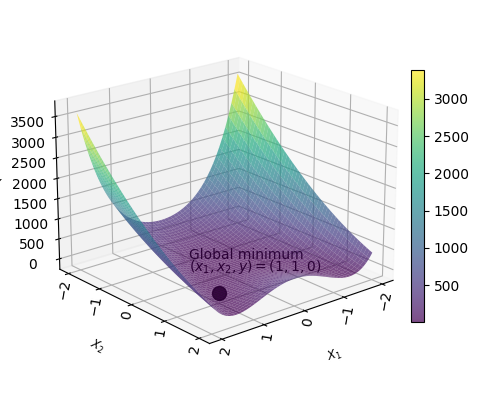

In [6]:
# Generate gridded sample data
N = 1000  # number of meshgrid points
x1 = np.linspace(-2, 2, N)
x2 = np.linspace(-2, 2, N)

# Generate meshgrids
X1, X2 = np.meshgrid(x1, x2)
Y = 100 * (X2 - X1**2)**2 + (1 - X1)**2  

# Plot data in 3D mode 
fig = plt.figure(figsize=(5,4.5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

surf = ax.plot_surface(X1, X2, Y, cmap='viridis', edgecolor='none',alpha=0.7) # plot 3D surface.
fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.01) # Add a color bar which maps values to colors.

# Other settings
ax.set_xlabel(r"$X_1$",rotation=80,fontweight='bold',fontsize='small')
ax.set_ylabel(r"$X_2$",rotation=80,fontweight='bold',fontsize='small')
ax.set_zlabel(r"$Y$",fontweight='bold',fontsize='small')

plt.xticks(rotation=80)
plt.yticks(rotation=80)
ax.tick_params(axis='x', which='major', pad=-5)
ax.tick_params(axis='y', which='major', pad=-5)

ax.view_init(20, 50) 
ax.scatter(1, 1, 0, s=100, c='k', marker="o", alpha=0.9)
ax.text(0.5, -0.5, 100, "Global minimum", color='k')
ax.text(0.5, -0.5, -200, "$(x_1,x_2,y)=(1,1,0)$", color='k')

fig.canvas.draw()
fig.tight_layout()

# Save figure
plt.show()
fig.savefig(os.path.join(outputDir,'function_3D.png'), dpi=150)
fig.savefig(os.path.join(outputDir,'function_3D.pdf'))
plt.close(fig)  


#### 2. Generate input-output data

In [7]:
# Specify sample file.
if os.path.exists(sampleFile): # If exist, remove samples.
    os.remove(sampleFile)

# Generate input data (x) 
x = np.zeros((nSample,nVar))
for iVar in range(nVar):
    prng = np.random.RandomState(iVar)
    x[:,iVar] = prng.uniform(low=paramLowerLimit, high=paramUpperLimit, size=nSample)               

# Generate the corresponding output data (y).
y = Rosenbrock_function(x)

# Save input-output data (x,y).
samples    = np.concatenate((x,y), axis=1)    
header_str = ','.join(['X'+str(iVar+1) for iVar in range(nVar)])+',Y'
np.savetxt(sampleFile, samples, delimiter=',', header=header_str)
print('Input-output data saved: %s'%(sampleFile))


Input-output data saved: ./outputs/samples_nVar2.txt


#### 3. Plot input-output, normalized, and CDF data
When we compute the first-order sensitivity index of $x_1$ for the Rosenbrock function, two variables $(x_1,y)$ need included in the VISCOUS framework. 
Through data preparation, three sets of data are obtained: input-output data $(x_1,y)$, normalized data $(x'_{1},y')$, and marginal CDF data $(u_{x_1},u_y)$.

In [8]:
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Normalize input-output data
x_norm = x.copy()
for ii in range(np.shape(x_norm)[1]):
    x_norm[:,ii] = vs.data_normalization(x[:,ii])
y_norm = vs.data_normalization(y)

# Calculate rank-based empirical marginal CDF
ux = x.copy()
for ii in range(np.shape(ux)[1]):
    ux[:,ii] = pseudo_obs(x[:,ii], ties='average')
uy = pseudo_obs(y, ties='average')


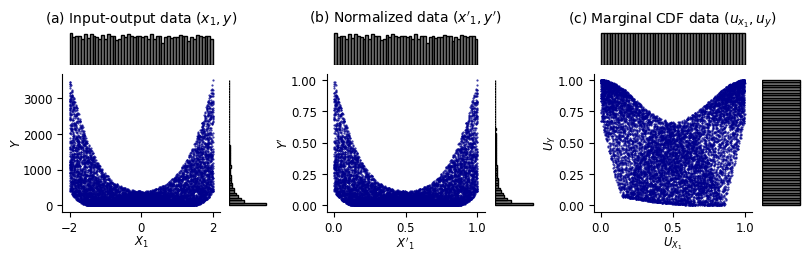

In [9]:
### PLOT ###
# set figure columns and rows
ndata   = 3        # three sets of data
ncols   = ndata*2  # number of columns 
nrows   = 2        # number of rows

# set figure width and heigh ratios
fig = plt.figure(figsize=(8,2.5),constrained_layout=True)
widths = [4,1,4,1,4,1]
heights = [1,4]
spec = fig.add_gridspec(nrows, ncols, width_ratios=widths, height_ratios=heights,
                        left=0.05, right=0.99, bottom=0.05, top=0.95, wspace=0.0, hspace=0.0)
# plot
for i in range(ndata):
    if i == 0:
        data_x,data_y = x[:,xIndex],y
        xlabel,ylabel = '${X_1}$','$Y$'
        title = '(a) Input-output data $(x_1, y)$'  
    elif i == 1:
        data_x,data_y = x_norm[:,xIndex],y_norm
        xlabel,ylabel = "${X'_1}$","$Y'$"  
        title = "(b) Normalized data $(x'_1, y')$"  
    elif i == 2:
        data_x,data_y = ux[:,xIndex],uy
        xlabel,ylabel = '${U_{X_1}}$','${U_{Y}}$'
        title = '(c) Marginal CDF data $(u_{x_1}, u_y)$'
           
    # Create the Axes.  
    ax = fig.add_subplot(spec[1, i*2])
    ax_histx = fig.add_subplot(spec[0, i*2], sharex=ax)
    ax_histy = fig.add_subplot(spec[1, i*2+1], sharey=ax)
    
    # the scatter plot and histogram plots:
    ax.scatter(data_x, data_y, c="darkblue",s=0.3,alpha=0.8)
    ax_histx.hist(data_x, bins=50, edgecolor = "black", color = 'gray')
    ax_histy.hist(data_y, bins=50, orientation='horizontal', edgecolor = "black", color = 'gray') 

    # labels
    ax_histx.set_axis_off()
    ax_histy.set_axis_off() 
    ax.spines[['right', 'top']].set_visible(False) # Hide the right and top spines
    
    # title
    ax_histx.set_title(title, fontsize='medium')

    ax.set_xlabel(xlabel, fontsize='small', fontweight='bold',labelpad=0)
    ax.set_ylabel(ylabel, fontsize='small', fontweight='bold',labelpad=0) 
    if i == 3:
        ax.set_ylabel(ylabel, fontsize='small', fontweight='bold',labelpad=-1) 
    ax.tick_params(axis='both', labelsize='small')
    
plt.savefig(os.path.join(outputDir,'data.png'), dpi=150)
plt.savefig(os.path.join(outputDir,'data.pdf'))
plt.show()


#### 4. Calculate the first-order sensitivity index using TWO components

##### 4.1 Calculate sensitivity index

In [10]:
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Calculate sensitivity indices using VISCOUS
sens_indx_2cpnt, gmcm_2cpnt = vs.viscous(x, y, xIndex, sensType, n_components=2)  


Calculating first-order sensitivity index for variable index [0]...
--- PART A: Data preparation
--- PART B: GMCM inference
    n_component = 2
	initial 1: fitting completes with convergency.
--- PART C: Sensitivity index computation
    Best GMCM n_component =  2
    Sensitivity index = 0.435549


##### 4.2 Plot the Gaussian mixture model (GMM) PDF and cluster
When using two Gaussian components, plot the histogram (panel a), GMM PDF (panel b), and GMM clustering (panel c) results for $(z_{x_1},z_y)$. $(z_{x_1},z_y)$ are the inverse CDFs of $(u_{x_1},u_y)$ in the fitted GMCM.  <br>
Note that due to the random nature of the GMCM inference process, the GMCM inference results may vary each time.

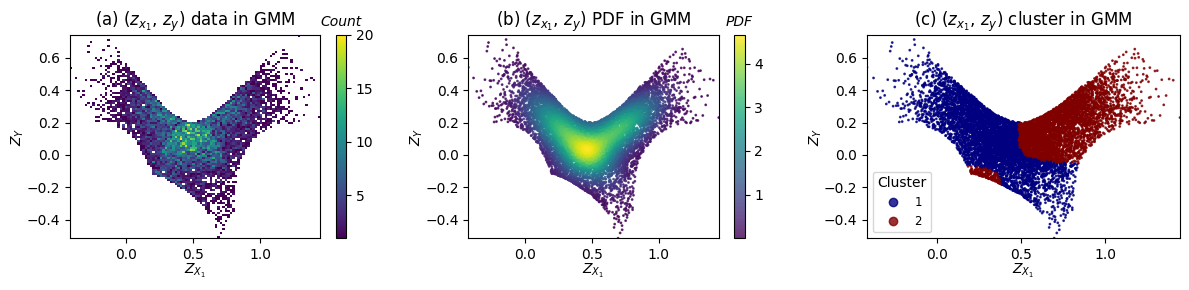

In [12]:
### PLOT ###
# Extract empirical CDF for evaluated input-output data
u = np.concatenate((ux[:,xIndex].reshape((-1,1)),uy),axis=1) 

# Get inverse CDF based on gmcm (implicitly realize via gmm)
z_2cpnt = vs.gmm_marginal_ppf(u, gmcm_2cpnt.params)  

# Output figure file
ofile  = os.path.join(outputDir,'gmm_2cpnt.png')

# Plot
plot_gmm_cluster_pdf(gmcm_2cpnt,z_2cpnt,ofile) 


#### 5. Calculate the first-order sensitivity index using the OPTIMAL number of components

##### 5.1 Calculate sensitivity index
When using the optimal number of Gaussian components, calculate the Sobol' first-order sensitivity index.

In [14]:
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Calculate sensitivity indices using VISCOUS
sens_indx_optm, gmcm_optm = vs.viscous(x, y, xIndex, sensType, n_components='optimal')  


Calculating first-order sensitivity index for variable index [0]...
--- PART A: Data preparation
--- PART B: GMCM inference
    n_component = 2
	initial 1: fitting completes with convergency.
    n_component = 3
	initial 1: fitting completes with convergency.
    n_component = 4
	initial 1: fitting completes with convergency.
    n_component = 5
	initial 1: fitting completes with convergency.
    n_component = 6
	initial 1: fitting completes with convergency.
    n_component = 7
	initial 1: fitting completes with convergency.
    n_component = 8
	initial 1: fitting completes with convergency.
    n_component = 9
	initial 1: fitting completes with convergency.
--- PART C: Sensitivity index computation
    Best GMCM n_component =  8
    Sensitivity index = 0.528853


##### 5.2 Plot the GMM PDF and cluster
When using the optimal number of Gaussian components, plot the histogram (panel a), GMM PDF (panel b), and GMM clustering (panel c) results for $(z_{x_1},z_y)$. $(z_{x_1},z_y)$ are the inverse CDFs of $(u_{x_1},u_y)$ in the fitted GMCM.

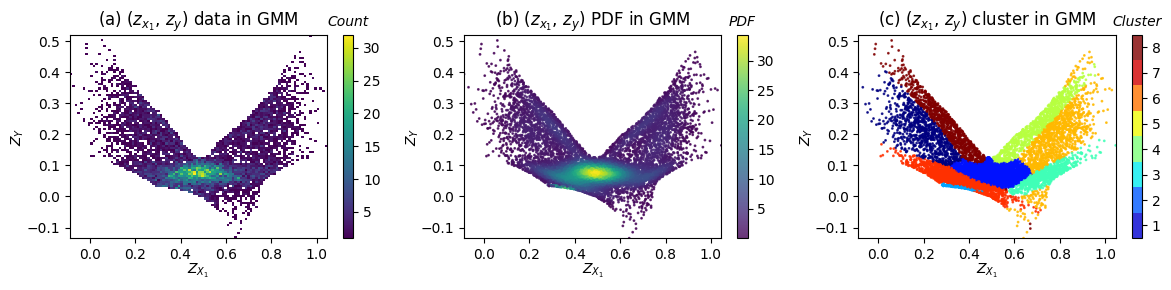

In [15]:
### PLOT ###
# Extract empirical CDF for evaluated input-output data
u = np.concatenate((ux[:,xIndex].reshape((-1,1)),uy),axis=1) 

# Get inverse CDF based on gmcm (implicitly realize via gmm)
z_optm = vs.gmm_marginal_ppf(u, gmcm_optm.params)  

# Output figure file
ofile  = os.path.join(outputDir,'gmm_optimal_cpnt.png')

# Plot
plot_gmm_cluster_pdf(gmcm_optm,z_optm,ofile) 


#### 6. Optional plots for better understanding GMM (Two components)

##### 6.1 Plot the GMM individual components
When using two Gaussian components, plot the individual GMM components via contour. A weighted mixture of all components constitutes the GMM. This plot is to help visualize how multiple Gaussian components constitute the GMM.

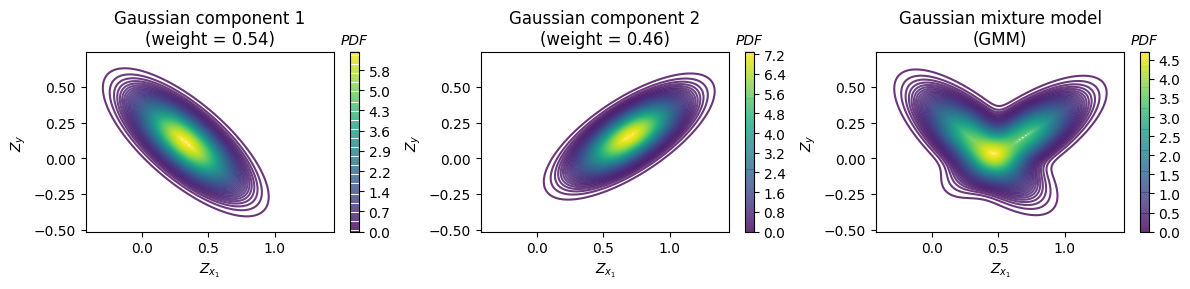

In [18]:
###############################################################################
#  Compute GMM PDF and invidivual componnet PDF at mesh grid points

# Get GMM weights, means, and covariances.
gmm = gmcm_2cpnt
gmmWeights         = gmm.params.prob          # shape (n_components,)
gmmMeans           = gmm.params.means         # shape (n_components, n_variables). n_variables = n_feature in sklearn.mixture.GaussianMixture reference.
gmmCovariances     = gmm.params.covs          # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    
gmmNComponents     = gmm.params.n_clusters    # number of components

# (1) Create mesh grid on (zx1,zy) dimensions for contour plot
N                  = 1000   # meshgrid points used in uniform sampling to create mesh grid
zx_2cpnt,zy_2cpnt  = z_2cpnt[:,xIndex], z_2cpnt[:,-1]
zx_min, zx_max     = np.min(zx_2cpnt),np.max(zx_2cpnt)
zy_min, zy_max     = np.min(zy_2cpnt),np.max(zy_2cpnt)
zx_uniform_samples = np.linspace(zx_min, zx_max, N)  # uniform samples in zx space [-3, 3] given the range of the standard normal distribution.
zy_uniform_samples = np.linspace(zy_min, zy_max, N)  # uniform samples in zy space [-3, 3]. 

zx_uniform_samples = zx_uniform_samples.reshape(-1,1) # reshape into (N,1)
zy_uniform_samples = zy_uniform_samples.reshape(-1,1) # reshape into (N,1)

X, Y = np.meshgrid(zx_uniform_samples, zy_uniform_samples)  # create mesh over N-N grids

# (2) Loop to calculate GMM PDF and invidivual component PDF per mesh grid point
jointPDF = np.zeros((N,N))                    # GMM PDF, dimension is (x,y).
jointPDFCpnt = np.zeros((N,N,gmmNComponents)) # Individual component PDF, dimension is (x,y,component).

# Loop zx 
for i in range(N):  
    xx, yy = zx_uniform_samples[i],zy_uniform_samples
    
    # Given xx, handle all the N samples of zy using vector operations   
    # Combine x and y into a multi-variate data array. Shape (N, n_variables).
    multivariateData = np.concatenate((np.ones((N,1))*xx,yy), axis=1)  
    # Calculate its joint probability in GMM.  
    jointPDF[:,i]    = gmm.pdf(multivariateData)  # pdf, taking z as input.
    
    # Calculate its individual component's PDF.
    for iComponent in range(gmmNComponents):
        jointPDFCpnt[:,i,iComponent] = multivariate_normal.pdf(multivariateData, 
                                                               mean=gmmMeans[iComponent,:],
                                                               cov=gmmCovariances[iComponent,:,:]) 
        
###############################################################################
# Plot GMM PDF and invidivual componnet PDF in contours
fs        = 'medium'  # plot font size
ncols     = 3         # three subplots per row
nrows     = int(np.ceil((gmmNComponents+1)/ncols)) # number of rows given ncols and gmmNComponents
fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(4*ncols,3*nrows))

# If the plot has only one row.
if nrows==1: 
    for icol in range(ncols):
        count = icol

        if count <= (gmmNComponents):
            if count == gmmNComponents:
                im = axes[icol].contour(X, Y, jointPDF, alpha=0.8,levels=100,cmap='viridis')
                axes[icol].set_title('Gaussian mixture model\n(GMM)')
            else:
                iComponent = count
                im = axes[icol].contour(X, Y, jointPDFCpnt[:,:,iComponent], alpha=0.8,levels=100,cmap='viridis')                
                axes[icol].set_title('Gaussian component %d\n(weight = %.2f)'%(iComponent+1, gmmWeights[iComponent]))

            # Set colorbar and tick label
            kwargs = {'format': '%.1f'}
            cbar = plt.colorbar(im, ax=axes[icol], **kwargs)
            cbar.ax.set_title('PDF',fontsize=fs, style='italic')    
            
            axes[icol].set_xlabel(r"$Z_{x_1}$")
            axes[icol].set_ylabel(r"$Z_y$")
        else:
            axes[icol].axis('off')

# If the plot has more than one rows.
elif nrows>1: 
    for irow in range(nrows):
        for icol in range(ncols):
            count = irow*ncols + icol 

            if count <= (gmmNComponents):
                if count == gmmNComponents:
                    im = axes[irow,icol].contour(X, Y, jointPDF, alpha=0.8,levels=100,cmap='viridis')
                    axes[irow,icol].set_title('Gaussian mixture model\n(GMM)')
                else:
                    iComponent = count
                    im = axes[irow,icol].contour(X, Y, jointPDFCpnt[:,:,iComponent], alpha=0.8,levels=100,cmap='viridis')                
                    axes[irow,icol].set_title('Gaussian component %d\n(weight = %.2f)'%(iComponent+1, gmmWeights[iComponent]))

                # Set colorbar and tick label
                kwargs = {'format': '%.1f'}
                cbar = plt.colorbar(im, ax=axes[irow,icol], **kwargs)
                cbar.ax.set_title('PDF',fontsize=fs, style='italic')
                
                axes[irow,icol].set_xlabel(r"$z_{X_1}$",fontsize=fs)
                axes[irow,icol].set_ylabel(r"$z_Y$",fontsize=fs)
            else:
                axes[irow,icol].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(outputDir,'gmm_2cpnt_contour.png'), dpi=150)
plt.show() 

##### 6.2 Plot GMM marginal distributions
When using two Gaussian components, plot the histogram of $z_{x_1}$ and $z_y$ data in the marginal distributions of GMM. $(z_{x_1},z_y)$ are the inverse CDFs of $(u_{x_1},u_y)$ in the fitted GMCM. For example, <br>
- The first subplot shows the two histograms of $z_{x_1}$ data in two $Z_{X_1}$ marginal distributions of GMM. <br>
- The two $Z_{X_1}$ marginal distributions are from the two GMM components. <br>

Note the following code is only valid for the first-order sensitivity. Please adjust for use of the total-order sensitivity.

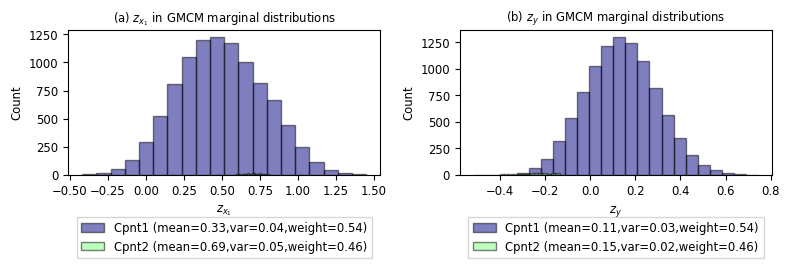

In [19]:
import matplotlib as mpl

# Extract empirical CDF for evaluated input-output data
u = np.concatenate((ux[:,xIndex].reshape((-1,1)),uy),axis=1) 

# Get inverse CDF based on gmcm (implicitly realize via gmm)
z_2cpnt = vs.gmm_marginal_ppf(u, gmcm_2cpnt.params)  

# Get GMM weights, means, and covariances.
gmm = gmcm_2cpnt
gmmWeights         = gmm.params.prob          # shape (n_components,)
gmmMeans           = gmm.params.means         # shape (n_components, n_variables). n_variables = n_feature in sklearn.mixture.GaussianMixture reference.
gmmCovariances     = gmm.params.covs          # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    
gmmNComponents     = gmm.params.n_clusters    # number of components

# Get the GMM clustering (label) results 
pdf_all_cpnts = np.zeros((len(data),gmmNComponents))
for n_component in range(gmmNComponents):
    mean, cov = gmmMeans[n_component,:],gmmCovariances[n_component,:,:]
    pdf_all_cpnts[:,n_component] = multivariate_normal.pdf(data[:,[0,-1]], mean, cov)
labels = np.argmax(pdf_all_cpnts, axis=1)

# Plot 
ncols   = 2
nrows   = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(4*ncols,3*nrows))

col = (np.arange(gmmNComponents))/(gmmNComponents)
cmap = mpl.colormaps['jet'] # 'viridis'

for icol in range(ncols):
    if icol == 0:
        title = '(a) $z_{x_1}$ in GMCM marginal distributions'
        xlabel,ylabel='$z_{x_1}$','Count'
        # loop each component and plot
        for iComponent in range(gmmNComponents):
            ax[icol].hist(z_2cpnt[labels==iComponent,0], bins=20, color=cmap(col[iComponent]),
                          edgecolor = 'black', alpha=0.5,
                          label='Cpnt%d (mean=%.2f,var=%.2f,weight=%.2f)'%(iComponent+1, gmmMeans[iComponent,0],
                                                                        gmmCovariances[iComponent,0,0], gmmWeights[iComponent]))

    elif icol == 1:
        title = '(b) $z_{y}$ in GMCM marginal distributions'
        xlabel,ylabel='$z_{y}$','Count'
        # loop each component and plot
        for iComponent in range(gmmNComponents):
            ax[icol].hist(z_2cpnt[labels==iComponent,-1], bins=20, color=cmap(col[iComponent]),
                          edgecolor = 'black', alpha=0.5,
                          label='Cpnt%d (mean=%.2f,var=%.2f,weight=%.2f)'%(iComponent+1, gmmMeans[iComponent,-1],
                                                                        gmmCovariances[iComponent,-1,-1], gmmWeights[iComponent]))

    ax[icol].set_title(title,fontsize='small')
    ax[icol].set_xlabel(xlabel,fontsize='small')#,labelpad=0)
    ax[icol].set_ylabel(ylabel,fontsize='small')#,labelpad=-5)
    ax[icol].tick_params(axis='both', labelsize='small')
    
    # Put a legend below current axis
    ax[icol].legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=False, shadow=False, ncol=1,fontsize='small')

plt.tight_layout()
ofile  = os.path.join(outputDir,'gmm_2cpnt_marginal_dists(optional).png')
plt.savefig(ofile, dpi=150)
plt.show()